<a href="https://colab.research.google.com/github/JorgeSC98/SpeechEmotion-Recognition/blob/main/Data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data extraction

This file reads the audio files, computes its features, creates a dataframe and stores it as a binary file.

In [ ]:
from google.colab            import files
from google.colab            import drive

import matplotlib.pyplot     as plt
import pandas                as pd
import seaborn               as sns
import numpy                 as np
import librosa
import soundfile
import os, glob, pickle

from tqdm import tqdm

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path     = '/content/gdrive/Shareddrives/CS4013/HW6/speech-emotion-recognition-ravdess-data/'
Ravdess = path

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
path_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
path_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
path_df.head()

,Emotions,Path
0,angry,/content/gdrive/Shareddrives/CS4013/HW6/speech...
1,fear,/content/gdrive/Shareddrives/CS4013/HW6/speech...
2,calm,/content/gdrive/Shareddrives/CS4013/HW6/speech...
3,sad,/content/gdrive/Shareddrives/CS4013/HW6/speech...
4,surprise,/content/gdrive/Shareddrives/CS4013/HW6/speech...


In [ ]:
unique, counts = np.unique( path_df.Emotions, return_counts = True )
dict( zip( unique, counts ) )

{'angry': 192,
 'calm': 192,
 'disgust': 192,
 'fear': 192,
 'happy': 192,
 'neutral': 96,
 'sad': 192,
 'surprise': 192}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


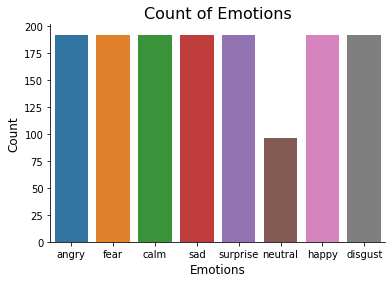

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(path_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
# Data Agumentation
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    # Spectral contrast
    sc = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
    result=np.hstack((result, sc))
    
    return result

In [ ]:
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

Define the emotions of interest

In [ ]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#observed_emotions=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

Create a database with all the features for each audio file

In [ ]:
import ntpath

def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

#DataFlair - Load the data and extract features for each sound file
def load_data(path_dataframe):
    X, Y = [], []

    print('Extracting features from audio files... ')

    for path, emotion in tqdm(zip(path_dataframe.Path, path_dataframe.Emotions), total=len(path_dataframe.Emotions)):

      file_name = path_leaf(path)
      emotion=emotions[file_name.split("-")[2]]
      
      if emotion not in observed_emotions:
          continue

      feature = get_features(path)

      for elem in feature:
        X.append(elem)
        Y.append(emotion)
    
    return X, Y

In [ ]:
X, Y = load_data(path_df)

Extracting features from audio files... 


100%|██████████| 1440/1440 [11:18<00:00,  2.12it/s]


Create a dataframe and save the results to a file

In [ ]:
os.listdir('/content/gdrive/Shareddrives/CS4013/HW6/data/')

['database.pkl', 'database_4emotions.pkl']

In [ ]:
database = pd.DataFrame(X)
database['labels'] = Y

# Save to file
output_folder = '/content/gdrive/Shareddrives/CS4013/HW6/data/'

if not os.path.exists(output_folder):
  os.makedirs(output_folder)

database.to_pickle(output_folder + 'database_4emotions.pkl')

database.head()

,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,labels
0,0.119855,0.507461,0.414120,0.401716,0.409684,0.421298,0.516690,0.537631,0.590918,0.640058,...,1.338648e-13,1.309344e-13,20.370474,18.402018,18.706955,17.229192,18.818294,18.757125,60.299300,fearful
1,0.272872,0.598629,0.556412,0.565423,0.577642,0.594398,0.611372,0.538784,0.579985,0.654674,...,9.955534e-05,1.028548e-04,14.896172,17.230610,17.458664,15.637138,15.465091,14.857155,14.319924,fearful
2,0.113133,0.606384,0.411250,0.374669,0.412562,0.385073,0.455472,0.502469,0.521309,0.601805,...,1.592488e-11,1.517740e-11,20.748005,18.602199,20.547905,18.824408,21.102303,20.811776,44.048627,fearful
3,0.121266,0.480263,0.422342,0.468604,0.466126,0.490174,0.548692,0.555605,0.593634,0.596291,...,5.084489e-12,5.084499e-12,21.361512,19.764985,20.110708,17.858791,19.005673,19.560215,60.839976,calm
4,0.253915,0.587318,0.601298,0.596231,0.615663,0.647406,0.576359,0.603092,0.619207,0.645742,...,3.304043e-04,3.335241e-04,14.709076,18.327844,18.166773,15.902382,15.985995,14.690535,13.897322,calm


# Data exploration

In [ ]:
import librosa.display

In [ ]:
def create_waveplot(data, sr, e):
    fig1 = plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()
    fig1.savefig('Waveplot.png')

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    fig = plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()
    fig.savefig('spectrogram.png')

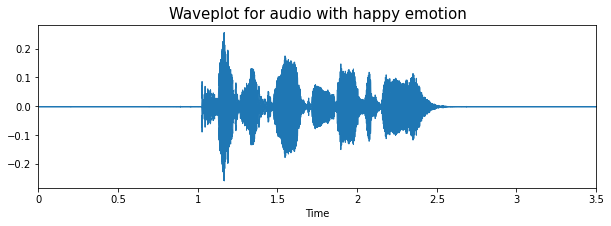

In [ ]:
emotion='happy'
path = np.array(path_df.Path[path_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
#create_spectrogram(data, sampling_rate, emotion)

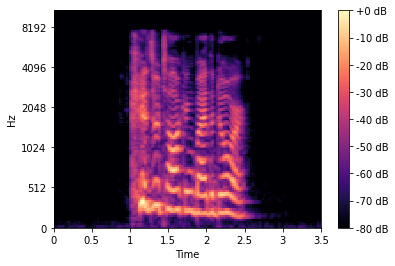

In [ ]:
S = librosa.feature.melspectrogram(data, sr=sampling_rate, n_fft = 2048, hop_length = 512, n_mels=128)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sampling_rate, hop_length=512, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');
plt.savefig('melspectrogram')